# Products image generation with Azure Open AI Dall-E3

<img src="products.gif">

In [1]:
# %pip install openai --upgrade

In [2]:
import datetime
import glob
import json
import math
import matplotlib.pyplot as plt
import openai
import os
import random
import requests
import sys
import time

from io import BytesIO
from dotenv import load_dotenv
from openai import AzureOpenAI
from PIL import Image

In [3]:
load_dotenv(".env")

# Azure Open AI
openai.api_type: str = "azure"
api_key = os.getenv("OPENAI_API_KEY")
api_base = os.getenv("OPENAI_API_BASE")
# api_version = "2023-12-01-preview"
api_version = "2024-06-01"
print("Open AI version:", openai.__version__)

Open AI version: 1.35.13


In [4]:
sys.version

'3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]'

In [5]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 12-Jul-2024 14:14:58


## Directory to save the generated images

In [6]:
images_dir = "dalle3_products_images"

os.makedirs(images_dir, exist_ok=True)

## Azure Open AI client

In [7]:
# Azure Open AI client
client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=api_base,
    api_key=api_key,
)

In [8]:
client

## Functions

In [9]:
def generate_prompt(product):
    """
    Generating a prompt
    """
    # Image attributes
    shot = random.choice(
        [
            #"extreme close-up shot",
            "close-up shot",
            "medium shot",
            "cowboy shot",
            "medium full shot",
            "full shot",
        ]
    )

    angle = random.choice(
        [
            "worm's eye view",
            "low view",
            "hero view",
            "straight on view",
            "above shot view",
            "bird's eye view",
            "top down view",
        ]
    )

    medium = random.choice(
        [
            "action photography",
            "autochrome",
            "back lighting",
            "camera obscura",
            "camera phone",
            "color splash",
            "fast shutter speed",
            "light leaks",
            "lomography",
            "long exposure",
            "low-key lighting",
            "macro lens",
            "polaroid",
            "raw photo",
            "shallow depth-of-field",
            "telephoto lens",
            "warm lighting",
        ]
    )

    # Product values
    color = random.choice(
        [
            "Andy Warhol colors style",
            "cyan",
            "blue",
            "gold",
            "white",
            "red",
            "camo",
            "green",
            "lime",
            "orange",
            "pastel colors",
            "pink",
            "purple",
            "rainbow",
        ]
    )

    place = random.choice(
        [
            "a beach",
            "a dusty floor",
            "a parquet floor",
            "a glass floor",
            "a marble floor",
            "a modern carpet",
            "a rusty floor",
            "a street",
            "a puddle",
            "some rocks",
            "a pavement",
            "a metallic floor",
            "a water puddle",
            "the grass",
        ]
    )

    # Random prompt
    prompt = f"{shot}, {medium}, {angle}, image of {color} {product} on {place}"

    return prompt

In [10]:
def dalle3(prompt, size="1792x1024", quality="hd", style="natural"):
    """
    Dall e3 image
    """
    result = client.images.generate(
        model="dall-e-3",  # Name of the Dall e3 deployed model
        prompt=prompt,  # Prompt
        n=1,  # Number of images
        size=size,  # 1792x1024 or 1024x1024 or 1024x1792
        quality=quality,  # hd or standard
        style=style,  # natural or vivid
        response_format="url"
    )
    # Loading the json results
    results = json.loads(result.model_dump_json())
    # Getting the url image (the first one)
    dalle_image = requests.get(results["data"][0]["url"]).content
    # Get PIL image
    img = Image.open(BytesIO(dalle_image))

    return img

## Examples

In [11]:
products = ["sneakers shoes", "loafers shoes", "high heels shoes", "boots"]

for product in products:
    print(product)

sneakers shoes
loafers shoes
high heels shoes
boots


In [12]:
nb_images_per_product = 4  # Number of images per product to generate

print("Generating Dall-E3 images...")
start = time.time()

for product in products:
    nb_image = 0
    print(f"\nProduct: {product}\n")
    # Creating a directory per product
    imgdir = os.path.join(images_dir, product)
    os.makedirs(imgdir, exist_ok=True)

    while nb_image < nb_images_per_product:
        # Getting the random prompt
        prompt = generate_prompt(product)
        print(f"{nb_image+1} Prompt: {prompt}")
        # Getting the Dalle 3 image
        img = dalle3(prompt, size="1792x1024", quality="hd", style="natural")
        # Saving the image
        img.save(os.path.join(imgdir, f"{prompt}_{nb_image+1}.png"))
        nb_image += 1

elapsed = time.time() - start
print(
    "\nDone. Elapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)

Generating Dall-E3 images...

Product: sneakers shoes

1 Prompt: close-up shot, telephoto lens, hero view, image of camo sneakers shoes on a metallic floor
2 Prompt: cowboy shot, action photography, hero view, image of orange sneakers shoes on a beach
3 Prompt: full shot, lomography, top down view, image of red sneakers shoes on a glass floor
4 Prompt: medium full shot, light leaks, worm's eye view, image of green sneakers shoes on some rocks

Product: loafers shoes

1 Prompt: full shot, low-key lighting, above shot view, image of camo loafers shoes on a beach
2 Prompt: cowboy shot, raw photo, above shot view, image of pink loafers shoes on some rocks
3 Prompt: full shot, low-key lighting, worm's eye view, image of camo loafers shoes on the grass
4 Prompt: cowboy shot, raw photo, top down view, image of rainbow loafers shoes on a modern carpet

Product: high heels shoes

1 Prompt: cowboy shot, fast shutter speed, worm's eye view, image of gold high heels shoes on a modern carpet
2 Prom

## Dall-E3 images visualisation

In [13]:
image_files = [
    os.path.join(root, file)
    for root, dirs, files in os.walk(images_dir)
    for file in files
    if file.lower().endswith((".png"))
]
print(f"Total number of generated images = {len(image_files)}")

Total number of generated images = 16


In [14]:
def view_multiple_images(images_list, product, num_cols=3):
    """
    Display multiple images
    """
    num_images = len(images_list)
    num_rows = math.ceil(num_images / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            image = plt.imread(images_list[idx])
            ax.imshow(image)
            ax.axis("off")

    plt.savefig(os.path.join(images_dir, f"plot_{product}.jpg"))
    plt.tight_layout()
    plt.show()

In [15]:
%%javascript

IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

Artificial images for product: sneakers shoes


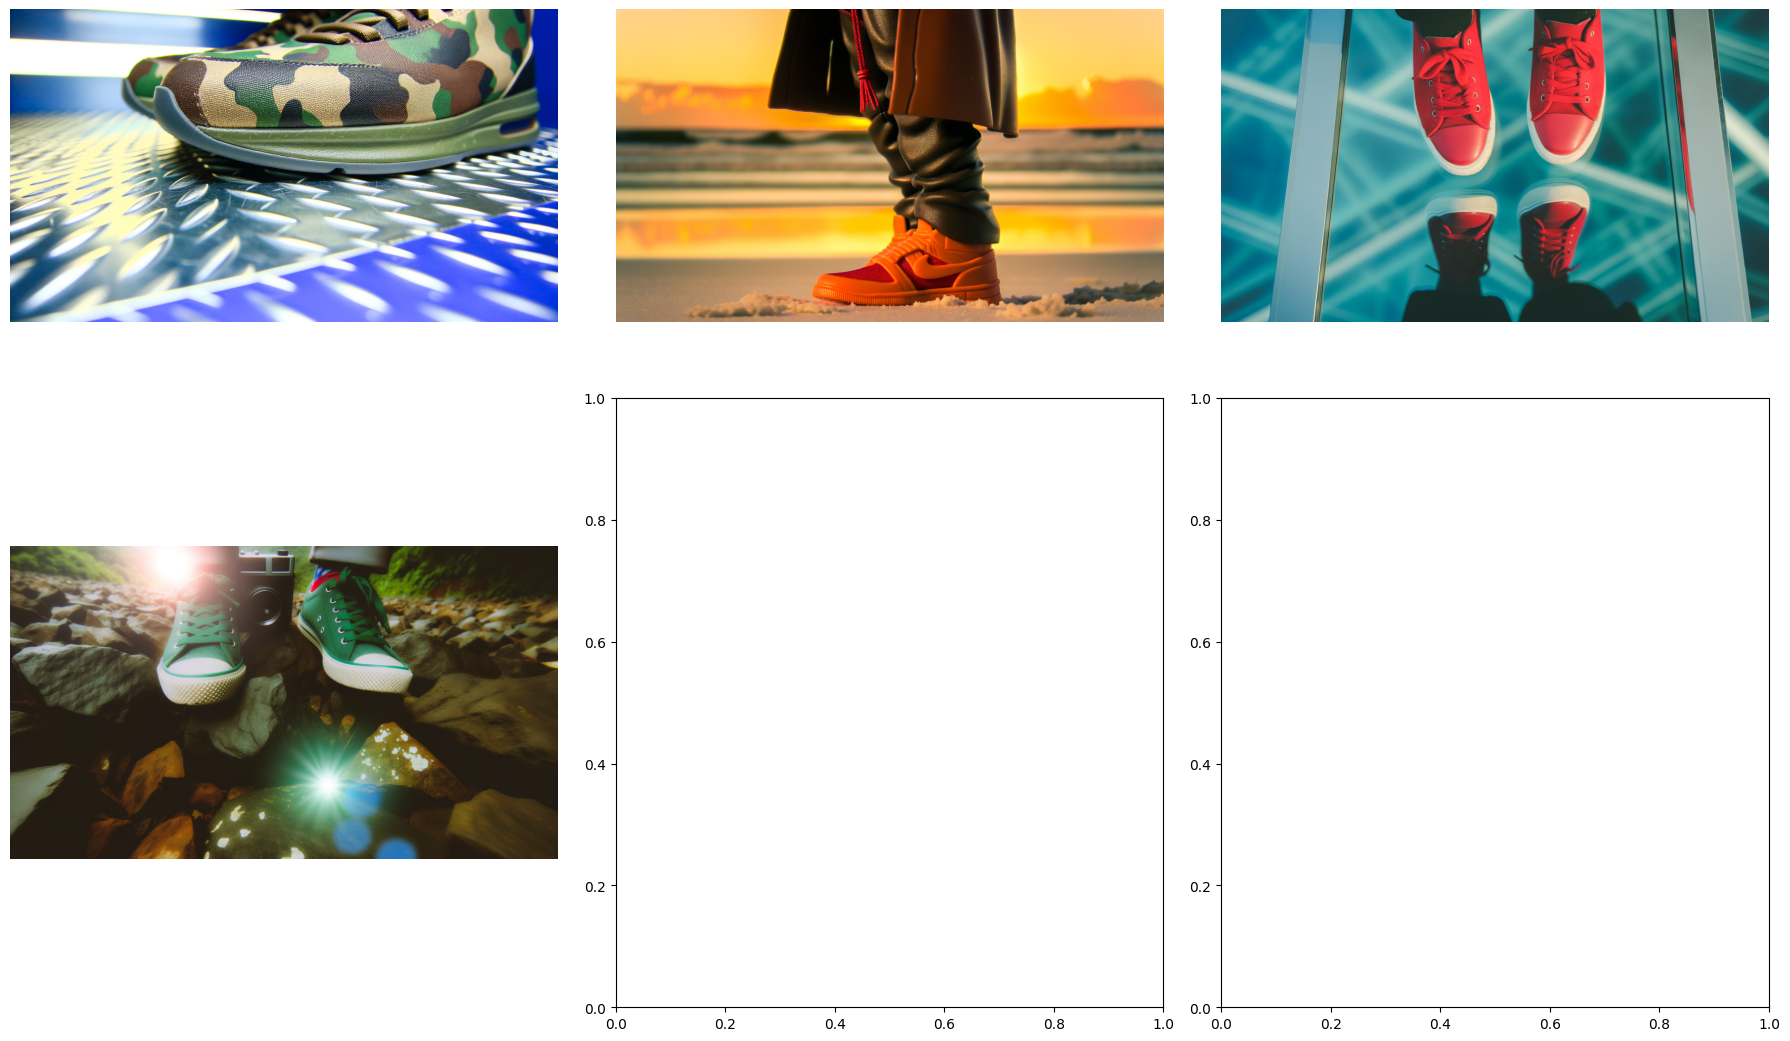

Artificial images for product: loafers shoes


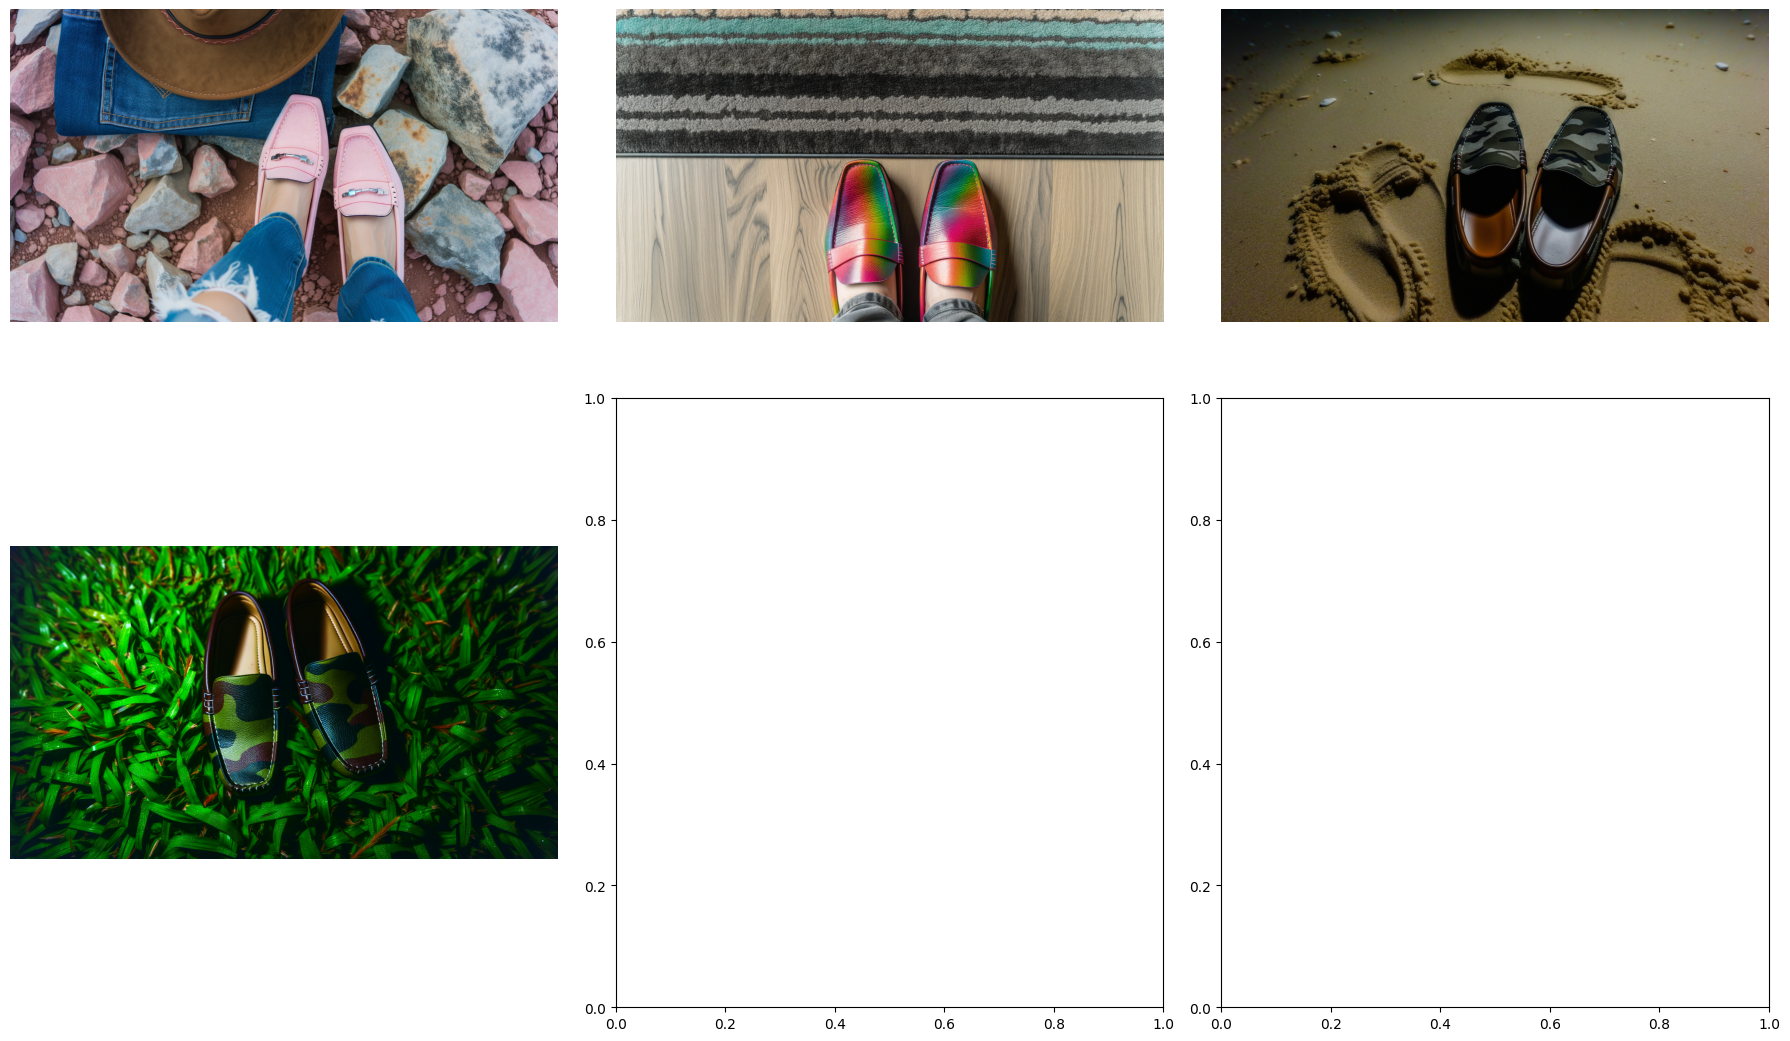

Artificial images for product: high heels shoes


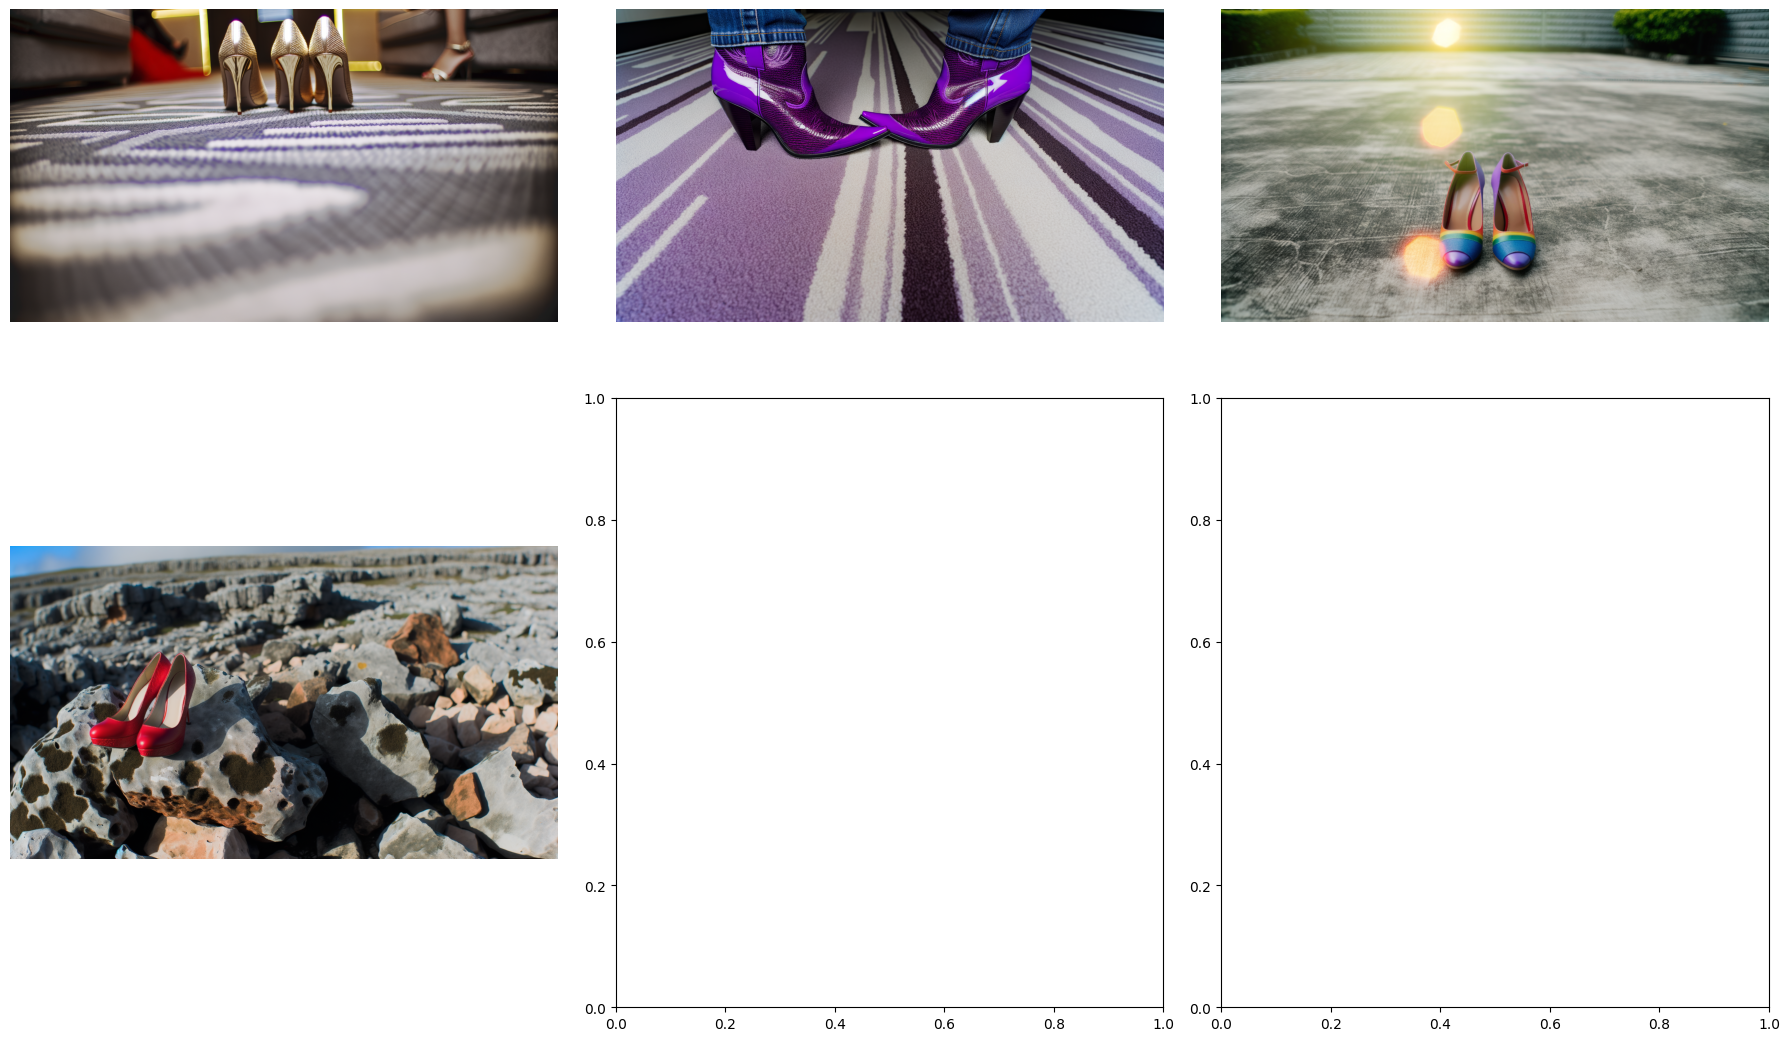

Artificial images for product: boots


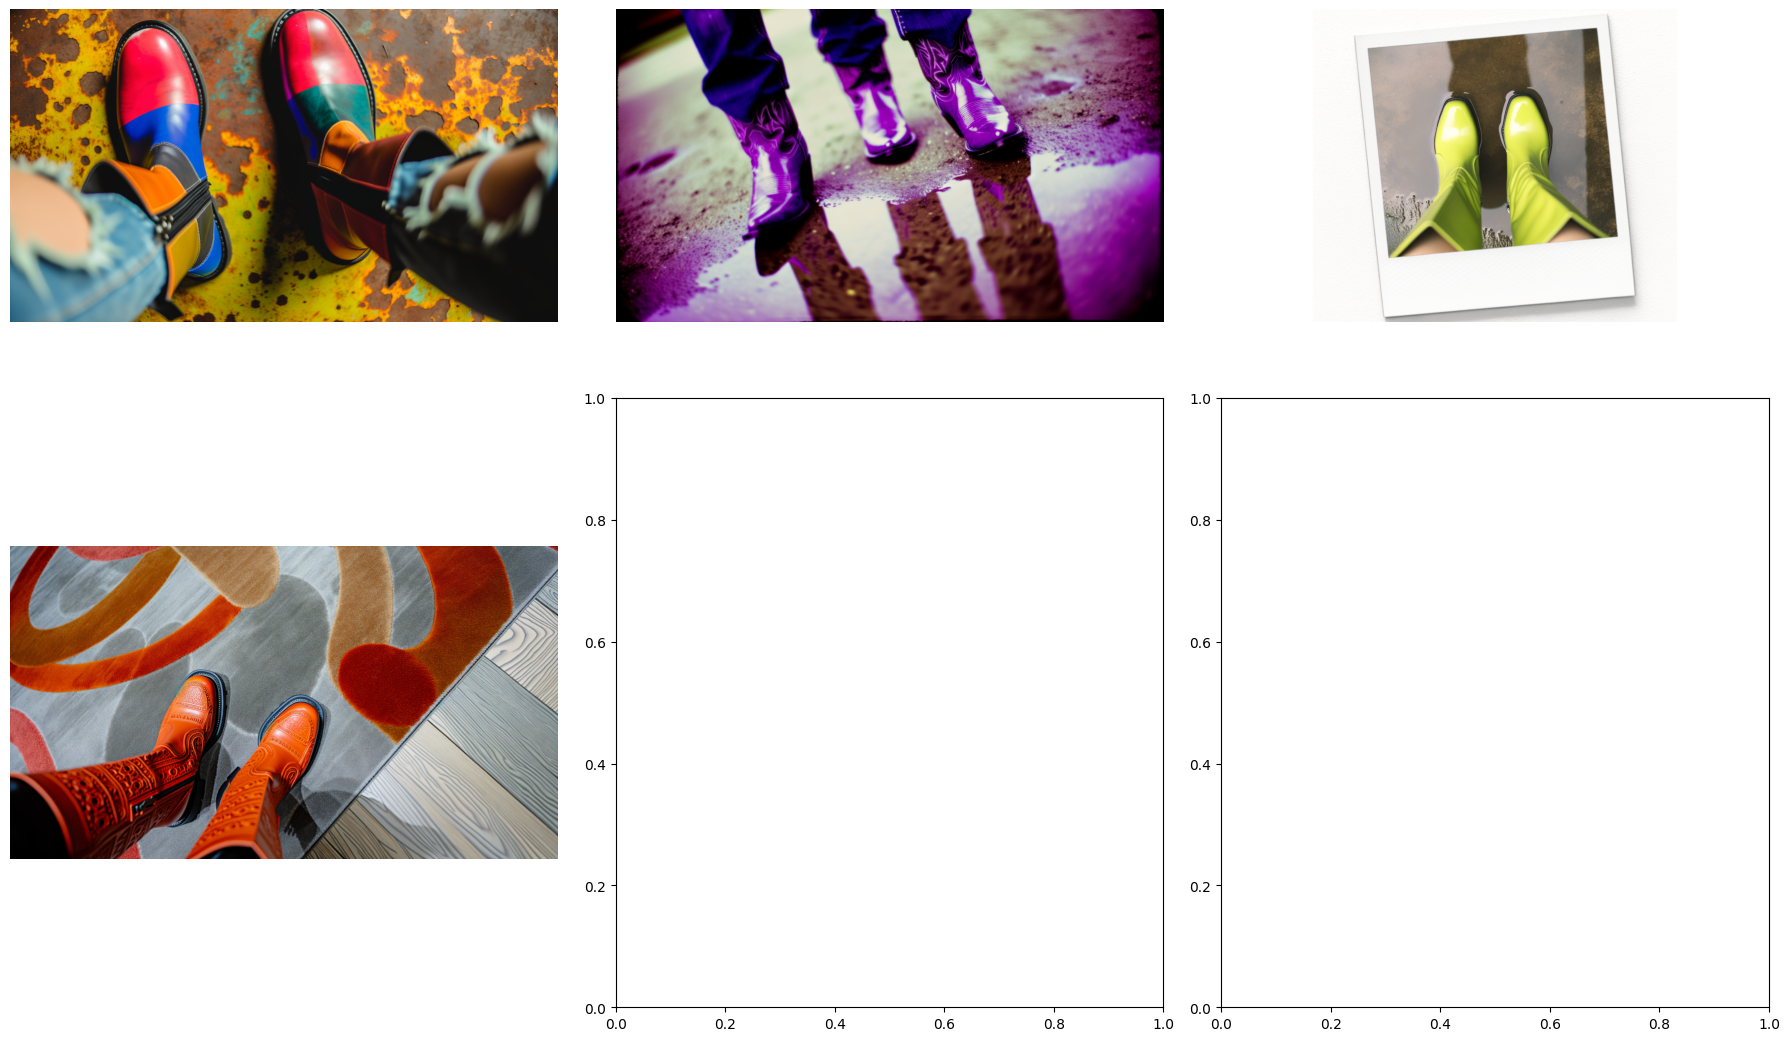

In [16]:
for product in products:
    print(f"Artificial images for product: {product}")
    # List of images per product
    images_list = glob.glob(os.path.join(images_dir, product, "*.png"))
    # Displaying images per product
    view_multiple_images(images_list, product)

In [17]:
!ls $images_dir -lh

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Viewing the images with ipyplot (optional)

In [19]:
import ipyplot

In [22]:
images = glob.glob(images_dir + "/**/*.png")
labels = [image.split("\\")[-2] for image in images]

ipyplot.plot_class_tabs(images, labels, max_imgs_per_tab=12, img_width=200)